# Multiclass multi-label classification using the Reuters dataset


This notebook shows how to implement document classification when each document can have multiple categories.

The dataset can be found [here](https://archive.ics.uci.edu/ml/machine-learning-databases/reuters21578-mld/). 
The topics to be predicted can be found in all-topics-strings.lc.txt. 
I'm adhering to the variable 'lewissplit' to define the Train/Test split. 

To convert the data from sgm to json, I'm drawing on convert_sgm_to_json.py by [mihaibogdan10](https://github.com/mihaibogdan10/json-reuters-21578).

I find the best model to predict topics is the linear support vector classifier, which gets an average F1 score of 51% accross 65 predicted labels, about 5% better than other models. Using a combined text column (original "body" + "title" + "unknown_processed") also improves the model performance by 6%. Further tuning the parameters of the SVC increases the F1 score to approx. 60%.  

In [27]:
import gzip
import collections
import matplotlib as plt
import seaborn as sns
%matplotlib inline
from os import listdir
import pandas as pd
import numpy as np
import json
import nltk
import itertools
import re
from time import time
from pandas.io.json import json_normalize
from utils import *

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, classification_report

# import english stopwords
stop_words = set(stopwords.words('english'))

# EDA

In [2]:
path = '/Users/twenzel/repos/topics2/json-data/'
files = listdir(path)

docs = [open_file(x, path) for x in files]
docs = list(itertools.chain(*docs))
docs_df = pd.DataFrame(docs)
docs_df['topic_length'] = docs_df.topics.apply(len)

# clean column "unknown" - as it helps classifying topics when document body is empty
docs_df['unknown_processed'] = docs_df.unknown.apply(lambda x: x.split('BC-')[-1]).apply(lambda x: x.split('  ')[0])

In [8]:
# analyse the category usage
docs_df.head()

,attrs,body,companies,date,dateline,exchanges,orgs,places,title,topics,unknown,topic_length,unknown_processed
0,"{'cgisplit': 'TRAINING-SET', 'lewissplit': 'TR...",The Bank of England said it forecast a\nshorta...,[],9-MAR-1987 04:58:41.12,"LONDON, March 9 -",[],[],[uk],U.K. MONEY MARKET SHORTAGE FORECAST AT 250 MLN...,[money-fx],&#5;&#5;&#5;RM\n&#22;&#22;&#1;f0416&#31;reute\...,1,U.K.-MONEY-MARKET-SHO
1,"{'cgisplit': 'TRAINING-SET', 'lewissplit': 'TR...",The Bank of France said it invited offers\nof ...,[],9-MAR-1987 05:03:09.75,"PARIS, March 9 -",[],[],[france],BANK OF FRANCE SETS MONEY MARKET TENDER,"[money-fx, interest]",&#5;&#5;&#5;RM\n&#22;&#22;&#1;f0423&#31;reute\...,2,BANK-OF-FRANCE-SETS-M
2,"{'cgisplit': 'TRAINING-SET', 'lewissplit': 'TR...",The U.S. &lt;Amoco Petroleum Corp> has\nreport...,[],9-MAR-1987 05:03:38.51,"PEKING, March 9 -",[],[],[china],AMOCO REPORTS SOUTH CHINA SEA OIL FIND,[crude],&#5;&#5;&#5;F\n&#22;&#22;&#1;f0426&#31;reute\n...,1,AMOCO-REPORTS-SOUTH-C
3,"{'cgisplit': 'TRAINING-SET', 'lewissplit': 'TR...",Technology transfer problems have delayed\nthe...,[],9-MAR-1987 05:12:17.12,"SEOUL, March 9 -",[],[],[south-korea],SOUTH KOREA DELAYS CONTRACT FOR NUCLEAR PLANTS,[],&#5;&#5;&#5;F\n&#22;&#22;&#1;f0437&#31;reute\n...,0,SOUTH-KOREA-DELAYS-CO
4,"{'cgisplit': 'TRAINING-SET', 'lewissplit': 'TR...",Keiaisha Co Ltd of Tokyo is issuing 12\nmln Sw...,[],9-MAR-1987 05:19:27.56,"ZURICH, March 9 -",[],[],[switzerland],KEIAISHA ISSUING 12 MLN SWISS FRANC NOTES,[],&#5;&#5;&#5;RM\n&#22;&#22;&#1;f0442&#31;reute\...,0,KEIAISHA-ISSUING-12-M


In [3]:
# Look at unique topics
topic_path = '/Users/twenzel/repos/topics2/other-data/all-topics-strings.lc.txt'
topics = pd.read_csv(topic_path).acq.tolist()
print(topics)

['alum', 'austdlr', 'austral', 'barley', 'bfr', 'bop', 'can', 'carcass', 'castor-meal', 'castor-oil', 'castorseed', 'citruspulp', 'cocoa', 'coconut', 'coconut-oil', 'coffee', 'copper', 'copra-cake', 'corn', 'corn-oil', 'cornglutenfeed', 'cotton ', 'cotton-meal', 'cotton-oil', 'cottonseed', 'cpi', 'cpu', 'crude', 'cruzado', 'dfl', 'dkr', 'dlr', 'dmk', 'drachma', 'earn', 'escudo', 'f-cattle', 'ffr', 'fishmeal', 'flaxseed', 'fuel', 'gas', 'gnp', 'gold', 'grain', 'groundnut', 'groundnut-meal', 'groundnut-oil', 'heat', 'hk', 'hog', 'housing', 'income', 'instal-debt', 'interest', 'inventories', 'ipi', 'iron-steel', 'jet', 'jobs', 'l-cattle', 'lead', 'lei', 'lin-meal', 'lin-oil', 'linseed', 'lit', 'livestock', 'lumber', 'lupin', 'meal-feed', 'mexpeso', 'money-fx', 'money-supply', 'naphtha     ', 'nat-gas', 'nickel', 'nkr', 'nzdlr', 'oat', 'oilseed', 'orange', 'palladium', 'palm-meal', 'palm-oil', 'palmkernel', 'peseta', 'pet-chem', 'platinum', 'plywood', 'pork-belly', 'potato', 'propane', 'ra

In [10]:
# Count frequency of topics used
cats_combo = list(itertools.chain(*docs_df.topics.tolist()))
counter=collections.Counter(cats_combo)
print(counter.most_common)

<bound method Counter.most_common of Counter({'earn': 3987, 'acq': 2448, 'money-fx': 801, 'crude': 634, 'grain': 628, 'trade': 552, 'interest': 513, 'wheat': 306, 'ship': 305, 'corn': 254, 'dlr': 217, 'oilseed': 192, 'money-supply': 190, 'sugar': 184, 'gnp': 163, 'coffee': 145, 'veg-oil': 137, 'gold': 135, 'nat-gas': 130, 'soybean': 120, 'bop': 116, 'livestock': 114, 'cpi': 112, 'reserves': 84, 'copper': 78, 'jobs': 76, 'cocoa': 76, 'carcass': 75, 'yen': 69, 'rice': 67, 'iron-steel': 67, 'gas': 65, 'ipi': 65, 'alum': 63, 'cotton': 63, 'barley': 54, 'meal-feed': 51, 'rubber': 51, 'zinc': 44, 'palm-oil': 43, 'pet-chem': 41, 'silver': 37, 'rapeseed': 35, 'lead': 35, 'sorghum': 35, 'tin': 33, 'strategic-metal': 32, 'wpi': 32, 'orange': 29, 'fuel': 28, 'hog': 27, 'soy-meal': 27, 'retail': 27, 'heat': 25, 'soy-oil': 25, 'housing': 21, 'stg': 21, 'income': 18, 'lei': 17, 'lumber': 17, 'sunseed': 17, 'dmk': 15, 'tea': 15, 'oat': 14, 'platinum': 12, 'nickel': 11, 'groundnut': 10, 'l-cattle': 9,

We see a lot of topics appear only ones. We will need to subset on the topics that appear at least a few times in the training and test set. More observations for these topics has to be collected to make meaningful predictions for these cases.

# Labels 

What are the most common labels?

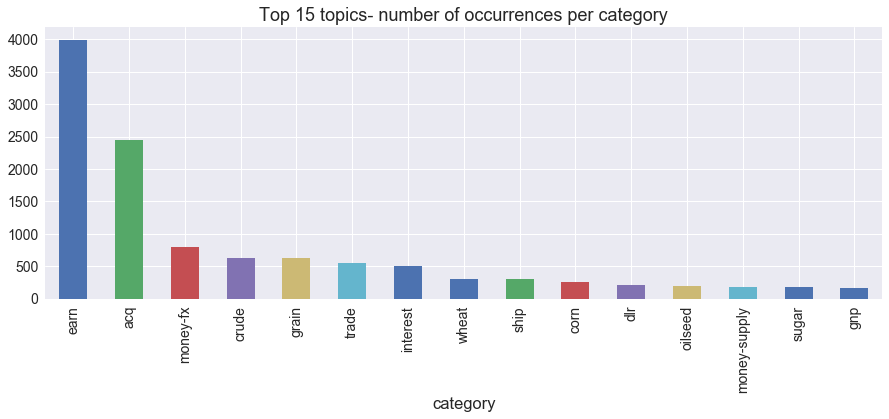

In [257]:
# plot topic frequencies
cat_df = pd.DataFrame.from_dict(counter, orient='index').reset_index()
cat_df.columns=['category', 'number_of_occurrences']
cat_df.sort_values(by = ['number_of_occurrences'], ascending=False, inplace=True)

cat_df.head(15).plot(x='category', 
                     y='number_of_occurrences', 
                     kind='bar', 
                     legend=False, 
                     grid=True, 
                     figsize=(15, 5), 
                     fontsize = 14,
                     title="Top 15 topics- number of occurrences per category")

# Multilabel 

How many articles have several labels?

47% of documents are not labelled.


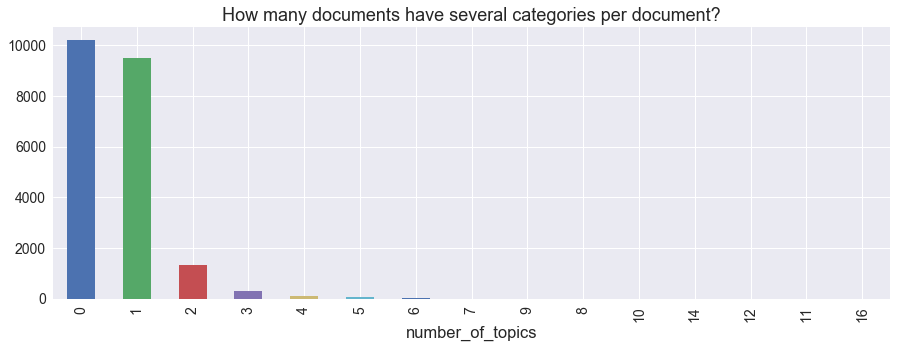

In [259]:
label_count_df = docs_df.topic_length.value_counts().reset_index()
label_count_df.columns = ['number_of_topics','number_of_occurrences']

label_count_df.plot(x='number_of_topics', 
                     y='number_of_occurrences', 
                     kind='bar', 
                     legend=False, 
                     grid=True, 
                     figsize=(15, 5), 
                     fontsize = 14,
                     title="How many documents have several categories per document?")
print('{:.0%} of documents are not labelled.'.format(docs_df[docs_df.topic_length==0].shape[0]/docs_df.shape[0]))

In [4]:
# Create dummies for each label - binary matrix over multiple labels
cat_df = pd.get_dummies(docs_df.topics.apply(pd.Series).stack()).sum(level=0)
# replace all 2s with 1
cat_df.replace(to_replace=2, value=1, inplace=True)
# combine 
docs_df = pd.concat([docs_df, cat_df], axis=1, join_axes=[docs_df.index]).fillna(0)

# Create attributes df
attr = pd.DataFrame()
for n in range(len(docs)):
    attr = attr.append(json_normalize(docs[n]['attrs']))
attr = attr.reset_index().drop('index',axis=1)
attr.drop('topics',axis=1, inplace=True)

# combine dfs
docs_df = pd.concat([docs_df, attr], axis=1, join_axes=[docs_df.index]).fillna(0)

# Imbalances

In [12]:
# Now that the lewissplit column is included in dataframe, we can check the multilabel occurrences acrocc train & test
docs_df[docs_df['lewissplit']!='NOT-USED'].groupby('lewissplit')['topic_length'].value_counts()

lewissplit  topic_length
TEST        0               3166
            1               2583
            2                310
            3                 64
            4                 32
            5                 14
            6                  6
            7                  4
            8                  2
            9                  2
            14                 2
            10                 1
            11                 1
            12                 1
TRAIN       0               6888
            1               6555
            2                892
            3                191
            4                 62
            5                 39
            6                 21
            7                  7
            8                  4
            9                  4
            10                 3
            12                 1
            16                 1
Name: topic_length, dtype: int64

In [17]:
# Imbalances: Check whether the same labels occur equally often in train and test
topiclist= cat_df.columns.tolist()
topiclist.extend(['lewissplit'])
data_to_plot = docs_df[topiclist][docs_df['lewissplit']!='NOT-USED']
data_to_plot = data_to_plot.groupby('lewissplit').sum().transpose()

# Creating a list of biggest categories to plot how imbalanced their frequencies are btw. test and train
all_cats = data_to_plot[data_to_plot.TEST>data_to_plot.TEST.mean()+(0.5*data_to_plot.TEST.std())].index.tolist()
train_cats = data_to_plot[data_to_plot.TRAIN>data_to_plot.TRAIN.mean()+(0.5*data_to_plot.TEST.std())].index.tolist()
all_cats.extend(train_cats)

# subset on selected categories and melt df for plotting 
data_to_plot = data_to_plot[data_to_plot.index.isin(all_cats)]
data_to_plot['topics'] = data_to_plot.index
data_to_plot = pd.melt(data_to_plot, id_vars="topics", var_name="split", value_name="frequency")

Text(0.5,1,'Imbalanced occurrences of topics btw. train and test set')

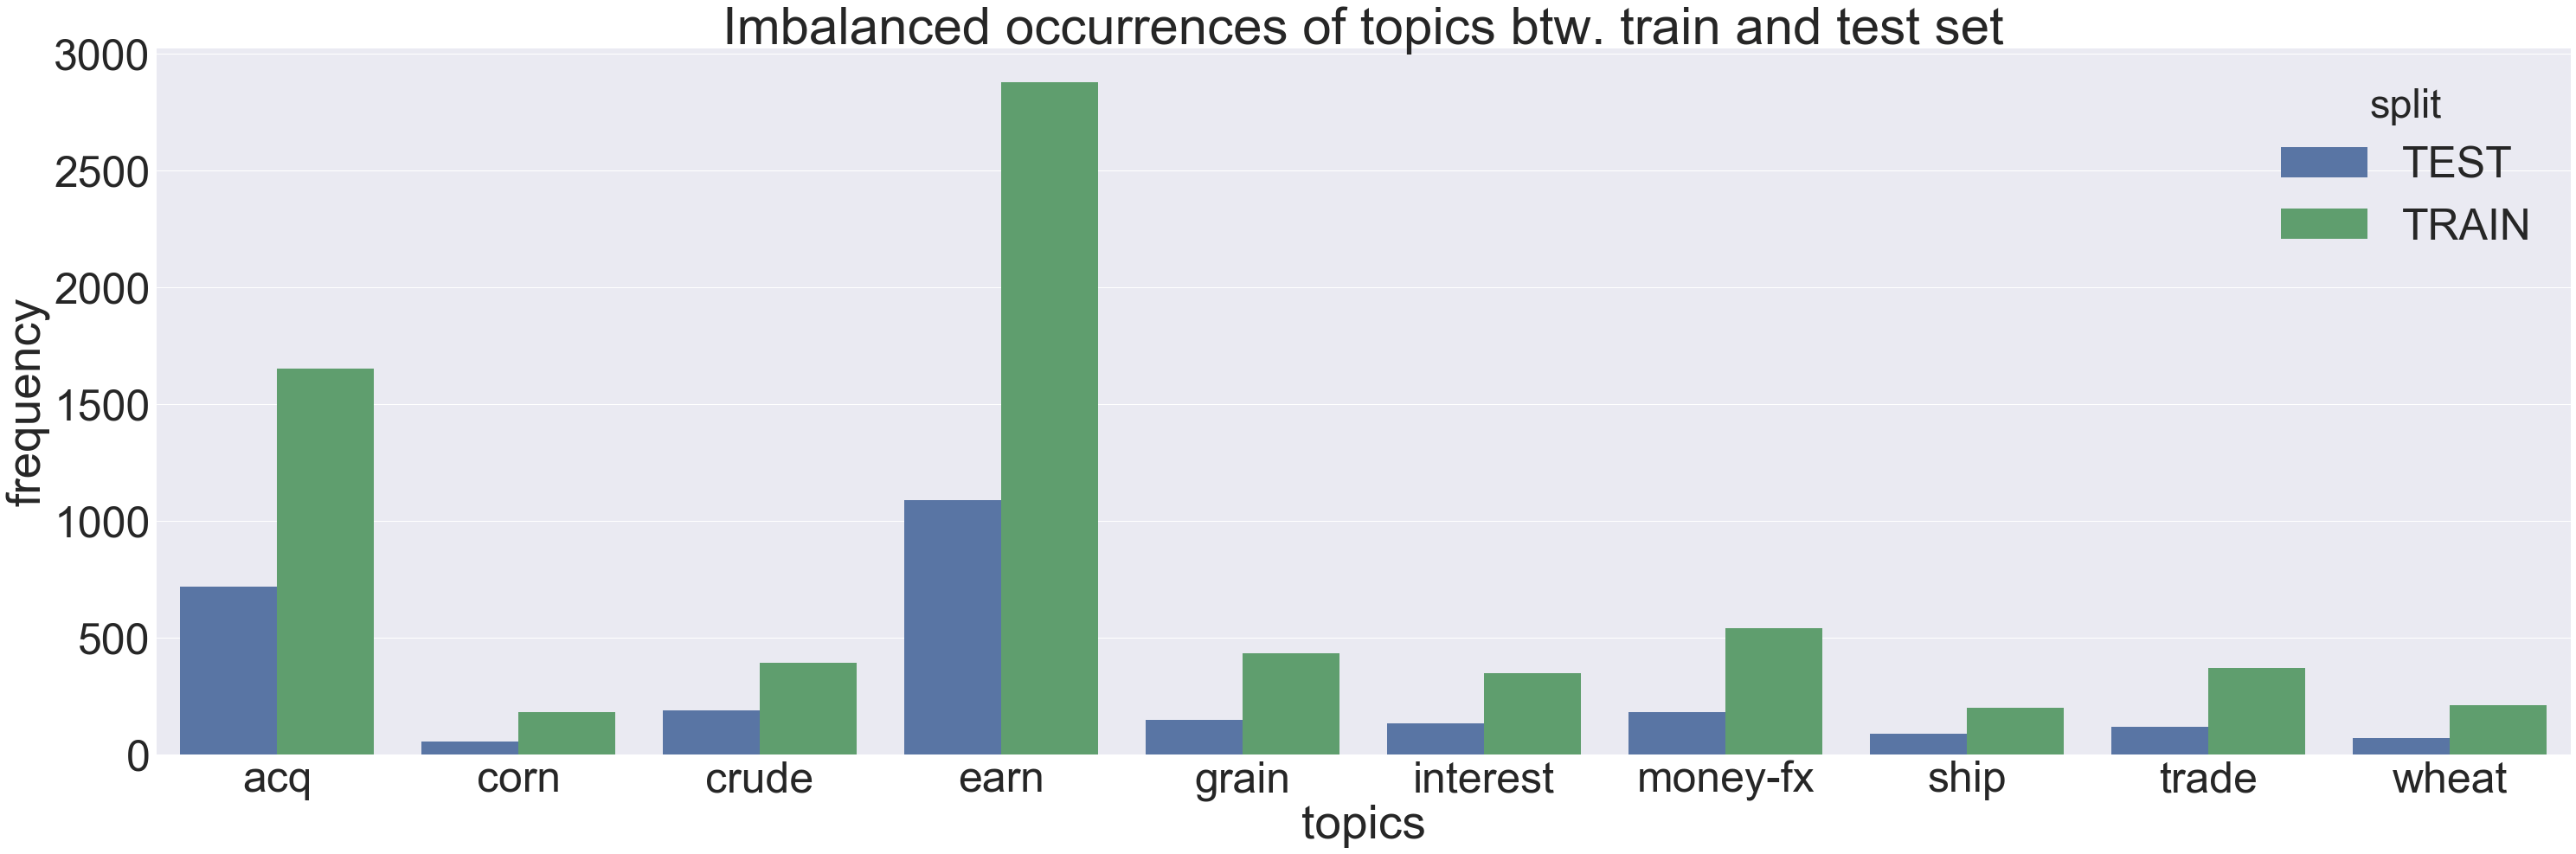

In [162]:
sns.set(rc={'figure.figsize':(50,15)})
sns.set(font_scale = 5)
sns.barplot(x="topics", 
            y="frequency", 
            hue="split", 
            data=data_to_plot).set_title("Imbalanced occurrences of topics btw. train and test set")

# Length of documents

Number of missing comments in comment text:{} 0
Most documents contain less than 508 characters. The longest document contains 13400 characters.


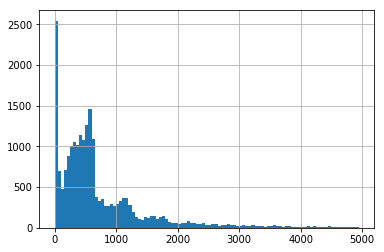

In [25]:
lens = docs_df.body.str.len()

print('Number of missing comments in document body:{}',format(docs_df['body'].isnull().sum()))

lens.hist(bins = np.arange(0,5000,50))
print('Most documents contain less than {} characters. The longest document contains {} characters.'
      .format(int(docs_df.body.str.len().median()),
              int(docs_df.body.str.len().max()))
     )

In [26]:
'We also see a large number of documents w/o any text: {}'.format(docs_df[docs_df.body.str.len()==0].shape[0])

'We also see a large number of documents w/o any text: 2535'

In [27]:
print('They are still allocated to training & test group as the below shows:')
docs_df[docs_df.body.str.len()==0].lewissplit.value_counts()

They are still allocated to training & test group as the below shows:


TRAIN       1803
TEST         730
NOT-USED       2
Name: lewissplit, dtype: int64

In [28]:
print('If the body is missing, the title and unknown field can be used to predict labels.')
docs_df[docs_df.body.str.len()==0][['title','unknown_processed','topics']].head()

If the body is missing, the title and unknown field can be used to predict labels.


,title,unknown_processed,topics
5,NATIONAL WESTMINSTER BANK SAYS IT CUTTING BASE...,NATIONAL-WESTMINSTER,[interest]
34,Chrysler to take over Renault stake in America...,Chrysler-to-take-over,[acq]
36,SOUTHERN CO TO TAKE 226 MLN DLR CHARGE ON PROJ...,******southern-co-to,[earn]
40,GENCORP TO SELL LOS ANGELES TELEVISION STATION...,******GENCORP-TO-SELL,[acq]
48,FRENCH JAN M-3 MONEY SUPPLY ROSE PROV ADJUSTED...,FRENCH-JAN-M-3-MONEY,[money-supply]


In [29]:
# 1 document is w/o body, title and unknown field. We will exclude it from Training.
docs_df[(docs_df.body.str.len()==0) & (docs_df.title.str.len()==0) & (docs_df.unknown_processed.str.len()==0)][['newid','unknown_processed','title','body','topics','lewissplit' ]]

,newid,unknown_processed,title,body,topics,lewissplit
9792,12793,,,,[],TRAIN


In [23]:
docs_df['body'] = docs_df.body.apply(lambda x: clean_text(x))
docs_df['unknown_processed'] = docs_df.unknown_processed.apply(lambda x: clean_text(x))
docs_df['unknown_processed'].head()

# Create additional text variable containing body, title & unknown_processed combined. This should help classifying documents where one of the fields, e.g. body is missing.
docs_df['txt_combined'] = docs_df['body'] + ' ' + docs_df['title'] + ' ' + docs_df['unknown_processed']

In [11]:
docs_df[['newid','unknown_processed','title','body','topics','txt_combined','lewissplit' ]].tail()

,newid,unknown_processed,title,body,topics,txt_combined,lewissplit
21573,16996,state of n j in m,STATE OF N.J. IN 43 MLN DLR PROGRAM STOCK SALE,the state of new jersey said that it sold st...,[],the state of new jersey said that it sold st...,NOT-USED
21574,16997,du pont lt dd conoco,DU PONT'S &lt;DD> CONOCO FINDS OIL OFFSHORE CONGO,du pont co conoco inc said the viodo marine nu...,[crude],du pont co conoco inc said the viodo marine nu...,NOT-USED
21575,16998,falconbridge lt falcf o,FALCONBRIDGE &lt;FALCF.O> SEES IMPROVED RESULTS,falconbridge ltd said it expected results for ...,"[nickel, acq]",falconbridge ltd said it expected results for ...,NOT-USED
21576,16999,symbol technologies lt,SYMBOL TECHNOLOGIES &lt;SMBL.O> FILES SHARE OFFER,symbol technologies inc said it filed with the...,[],symbol technologies inc said it filed with the...,NOT-USED
21577,17000,transcanada lt trp den,TRANSCANADA &lt;TRP> DENIES REPORTS OF NEW BID,transcanada pipelines ltd denied reports that ...,[acq],transcanada pipelines ltd denied reports that ...,NOT-USED


# Train test split

In [24]:
X_train = docs_df[(docs_df.lewissplit=='TRAIN') & (docs_df.newid !=12793)]
X_test = docs_df[(docs_df.lewissplit=='TEST')].drop('topics', axis=1)

# categories to predict - subset on categories that appear more than twice in the training & test set
cat_obs_count_train = X_train[cat_df.columns.tolist()].sum()>5
categories_with_enough_obs = cat_obs_count_train[cat_obs_count_train.values].index.tolist()

cat_obs_count_test = X_test[cat_df.columns.tolist()].sum()>5
categories_with_enough_obs_test = cat_obs_count_test[cat_obs_count_test.values].index.tolist()
categories_with_enough_obs.extend(categories_with_enough_obs_test)

print('Some topics only occur once or twice. To ensures that we can calculate model performance metrics, we will use only {}/120 topics for prediction.  (In practice, a much higher threshold should be set, e.g. 20 times to train a classifier for a label.)'.format(len(categories_with_enough_obs)))

Some topics only occur once or twice. To ensures that we can calculate model performance metrics, we will use only 123/120 topics for prediction.  (In practice, a much higher threshold should be set, e.g. 20 times to train a classifier for a label.)


# Train classifier

Next we train a classifier that fits our problem. We have multiple classes (120 topics) amd each document can belong to multiple classes (up to 16) at the same time. A multi-class multi-label classifier is appropriate in such situations and can be implemented in scikit-learn. 

### OneVsRest multi-label strategy
The OneVsRest strategy can be used for multi-label learning, where a classifier is used to predict multiple labels for each input. This classifier accepts a binary mask over multiple labels. We constructed this in cat_df. The result for each prediction will be an array of 0s and 1s marking which class labels apply to each row input sample.

### Linear classifiers
The next step implements several linear classifiers: Multi-class version of Naive Bayes (MultinomialNB), stochastic gradient descent (SGDClassifier), Support Vector (LinearSVC), Stochastic gradient descent (SGDClassifier).

### Non-linear classifiers
To allow for more complex relationship modeling, I compare the linear classifiers to a multi-layer perceptron (MLP) classifier. 

### Why are these models suitable? 

**Naive Bayes** and **SVM** are often considered baseline models in text classification. 

**Naive Bayes** classifier is suitable for classification with discrete features (e.g., word counts for text classification). 
- It assumes that the probability of occurrence of any word given the class label, is independent of the probability of occurrence of any other word, given its class label.
- It also assumes the probability of occurrence of a word in a document, is independent of the location of that word within the document.

Text data roughly follows these assumptions, making naive Bayes a good model for text classification problems.  
I used the multinomial version here because

The **linear support vector machine** extracts the best possible hyper-plane / line that segregates the two classes. It has been found to be one of the best models for text classification. The linear kernel SVM is often recommended for text classification because text is often linearly separable, text has a lot of features. The linear Kernel is most suitable for these cases and is also than other Kernels. 

It has been [found](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf) that NB works better for shorter texts, whereas SVM works better for longer texts. Since the Reuters dataset also has longer documents, this may be one of the reasons why SVM performs best here. 


**Logistic Regression** classifier measures the relationship between the categorical dependent variable and independent variables by estimating probabilities using a sigmoid function. It is a great baseline model 

**SDG** is a simple and efficient numerical optimisation method that is used in many machine learning applications. Stochastic gradient descent classifier is a linear classifier (SVM, logistic regression) that uses SGD for training (minimising the loss function). 
Linear classifiers (SVM, logistic regression, a.o.) with SGD training, whereby the loss function determins the classifier. ‘Log’ loss gives logistic regression, ‘hinge’ (default) gives a linear SVM.

A **multi-layer perceptron** is a feedforward neural network that has three or more layers. It utilizes a nonlinear activation function (mainly hyperbolic tangent or logistic function) that lets it classify data that is not linearly separable. Every node in a layer connects to each node in the following layer making the network fully connected.
MPL can get better results than NB or SVM because of the non-linearity introduced which is present in some text classification problems. It's worth trying since it can distinguish classes that is not linearly separable and the other models do not allow for non-linearity.


### Pipeline
In order to make the vectorizer => transformer => classifier easier to work with, scikit-learn provides a Pipeline class that behaves like a compound classifier. 

The text is passed into a processing step (TfidfVectorizer), which converts a collection of raw documents to a matrix of TF-IDF features. This step counts the term frequencies in the text and scales down terms that occur very frequently in the corpus of documents. Hence, less informative terms have lower values. 

### Model performance metrics
I chose F1 score as evaluation metric to optimise, since it is more robust to imbalanced classes than, e.g. the accuracy score. Using the accuracy score, it is easy to get a score around 99% by simply predicting the majority class, which is zero. 

There are other options: 
- Converting the labels to numbers, one could predict multiple labels from the predictions as output and use the recommended F1 scoring method 'f1_samples' in the GridSearch step.
- Label ranking average precision: The correct labels should be ranked higher and this metric yields better scores if the model is able to give better rank to the labels associated with each sample. 


# Tuning
I use randomized search, which search the parameter space more efficiently than exhaustive GridSearch.

### Possible extensions
- Ensemble: train several classifiers on other non-text variables and combine predictions of text and non-text models. For example, performance can be improved by training 1 classifier using text, another using the non-text information in the documents and then combining the 2 classifiers in an ensemble. 
- Keras implementations to scale on bigger dataset, e.g. [Reuters dataset](https://github.com/philipperemy/Reuters-full-data-set)
- Try [nlp.fast.ai](http://nlp.fast.ai/classification/2018/05/15/introducting-ulmfit.html) and [Facebook fastText](https://github.com/facebookresearch/fastText) 
- Explore bigger parameter space using further efficiency improvements (early stopping in random search)
- Feature engineering: e.g. word embedding layers for deep learning with Keras, Word2Vec, GloVe
- Rerun models on full Reuters dataset 

# LinearSVC

In [18]:
# silence some warnings (version incompatibilities btw. h5py and numpy)
import warnings
warnings.simplefilter('ignore')

In [14]:
SVC_clf = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC())),
            ])
svc_scores = {}
for category in categories_with_enough_obs:
    print('... Processing {}'.format(category))
    # train the model using train_body & y_class
    SVC_clf.fit(X_train.body, X_train[category])
    # compute the testing F1 score
    prediction = SVC_clf.predict(X_test.body)
    f1_value = f1_score(X_test[category], prediction)
    svc_scores[category] = f1_value
    print('Test F1 score is {}'.format(f1_value))

... Processing oilseed
Test F1 score is 0.5714285714285714
... Processing reserves
Test F1 score is 0.6153846153846153
... Processing gold
Test F1 score is 0.41860465116279066
... Processing wpi
Test F1 score is 0.5714285714285715
... Processing cocoa
Test F1 score is 0.6666666666666666
... Processing acq
Test F1 score is 0.754047802621434
... Processing ship
Test F1 score is 0.6222222222222222
... Processing soy-meal
Test F1 score is 0.14285714285714288
... Processing meal-feed
Test F1 score is 0.2727272727272727
... Processing strategic-metal
Test F1 score is 0.0
... Processing yen
Test F1 score is 0.0
... Processing wheat
Test F1 score is 0.7438016528925621
... Processing cpi
Test F1 score is 0.3888888888888889
... Processing rapeseed
Test F1 score is 0.6153846153846153
... Processing silver
Test F1 score is 0.0
... Processing bop
Test F1 score is 0.5454545454545455
... Processing cotton
Test F1 score is 0.6666666666666666
... Processing income
Test F1 score is 0.0
... Processing ho

In [15]:
SVC_clf = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', LinearSVC()),
            ])
svc_scores2 = {}
for category in categories_with_enough_obs:
    print('... Processing {}'.format(category))
    # train the model using train_body & y_class
    SVC_clf.fit(X_train.txt_combined, X_train[category])
    # compute the testing F1 score
    prediction = SVC_clf.predict(X_test.txt_combined)
    f1_value = f1_score(X_test[category], prediction)
    svc_scores2[category] = f1_value
    print('Test F1 score is {}'.format(f1_value))

... Processing oilseed
Test F1 score is 0.5675675675675675
... Processing reserves
Test F1 score is 0.6896551724137931
... Processing gold
Test F1 score is 0.5531914893617021
... Processing wpi
Test F1 score is 0.8235294117647058
... Processing cocoa
Test F1 score is 0.75
... Processing acq
Test F1 score is 0.8237015362106802
... Processing ship
Test F1 score is 0.6330935251798561
... Processing soy-meal
Test F1 score is 0.14285714285714288
... Processing meal-feed
Test F1 score is 0.2727272727272727
... Processing strategic-metal
Test F1 score is 0.0
... Processing yen
Test F1 score is 0.0
... Processing wheat
Test F1 score is 0.8031496062992126
... Processing cpi
Test F1 score is 0.5128205128205129
... Processing rapeseed
Test F1 score is 0.6153846153846153
... Processing silver
Test F1 score is 0.0
... Processing bop
Test F1 score is 0.68
... Processing cotton
Test F1 score is 0.5714285714285715
... Processing income
Test F1 score is 0.4444444444444445
... Processing hog
Test F1 sco

In [92]:
# Comparing the performance btw.'body' and 'txt_combined'
diff = {x: svc_scores2[x] - svc_scores[x] for x in svc_scores2 if x in svc_scores}
print('Using the combined text variable "txt_combined" instead of "body", improves the F1 score by {:.2g}% on average'.format(100*(sum(diff.values())/len(diff))))

Using the combined text variable "txt_combined" instead of "body", improves the F1 score by 5.5% on average


A point to note is that the performance for documents with "body" actually seems to worsen. A better feature would be to use "txt_combined" whenever "body" is empty.

In [114]:
# Print largest coefficients
vec, clf = SVC_clf.named_steps['tfidf'], SVC_clf.named_steps['clf']
coefs = pd.Series(clf.coef_[0], index=vec.get_feature_names())
print("\n20 most discriminating words:")
print(coefs[coefs.abs().sort_values(ascending=False).index][:20])


20 most discriminating words:
shipping        2.631469
ships           2.341930
vessels         2.072995
port            1.945230
vessel          1.706659
mt              1.581577
seamen          1.579861
cargo           1.427407
ship            1.311303
canal           1.301302
sea             1.231398
freight         1.214308
tankers         1.202379
dwt             1.171242
transport       1.162541
harbour         1.116598
river           1.090166
tanker          1.048441
warships        1.048380
shipbuilding    0.948403
dtype: float64


# Stochastic gradient descent 

In [228]:
SGD_clf = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(SGDClassifier())),
            ])
sgd_scores = {}
for category in categories_with_enough_obs:
    print('... Processing {}'.format(category))
    # train the model using train_body & y_class
    SGD_clf.fit(X_train.body, X_train[category])
    # compute the testing F1 score
    prediction = SGD_clf.predict(X_test.body)
    f1_value = f1_score(X_test[category], prediction)
    sgd_scores[category] = f1_value
    print('Test F1 score is {}'.format(f1_value))

... Processing oilseed
Test F1 score is 0.3728813559322034
... Processing reserves
Test F1 score is 0.3636363636363636
... Processing gold
Test F1 score is 0.4888888888888889
... Processing wpi
Test F1 score is 0.0
... Processing cocoa
Test F1 score is 0.6666666666666666
... Processing acq
Test F1 score is 0.7533281127642913
... Processing ship
Test F1 score is 0.6277372262773723
... Processing soy-meal
Test F1 score is 0.0
... Processing meal-feed
Test F1 score is 0.0
... Processing strategic-metal
Test F1 score is 0.0
... Processing yen
Test F1 score is 0.0
... Processing wheat
Test F1 score is 0.7304347826086957
... Processing cpi
Test F1 score is 0.4
... Processing rapeseed
Test F1 score is 0.6153846153846153
... Processing silver
Test F1 score is 0.0
... Processing bop
Test F1 score is 0.4878048780487804
... Processing cotton
Test F1 score is 0.5714285714285715
... Processing income
Test F1 score is 0.0
... Processing hog
Test F1 score is 0.0
... Processing lead
Test F1 score is 0

In [103]:
# Comparing SVC vs. SGD model performance 
diff = {x: svc_scores2[x] - sgd_scores[x] for x in svc_scores2 if x in sgd_scores}
print('Using a default SVC instead of SGD classifier improves the F1 score by {:.0%} on average'.format(sum(diff.values())/len(diff)))

Using a default SVC instead of SGD classifier improves the F1 score by 14% on average


Hence the best default model remains the Support vector classifier. 

# MultinomialNB

We notice that the multinomial version of naive Bayes does not predict any positive classes. Hence F1 score is always 0. 

In [50]:
# precision = TP/(TP+FP) as you've just said if predictor doesn't predicts positive class at all - precision is 0.
# recall = TP/(TP+FN), in case if predictor doesn't predict positive class - TP is 0 - recall is 0.
# So now you are dividing 0/0.
NB_clf = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB( 
                        fit_prior=False, class_prior=None))),
            ])

nb_scores = {}
for category in categories_with_enough_obs:
    print('... Processing {}'.format(category))
    # train the model using train_body & y_class
    NB_clf.fit(X_train.txt_combined, X_train[category])
    # compute the testing F1 score
    prediction = NB_clf.predict(X_test.txt_combined)
    f1_value = f1_score(X_test[category], prediction)
    nb_scores[category] = f1_value
    print('Test F1 score is {}'.format(f1_value))
print('Mean F1 score of Multinomial naive Bayes: {}.'.format(sum(nb_scores.values())/len(nb_scores.values())))

... Processing acq
Test F1 score is 0.4364012409513961
... Processing alum
Test F1 score is 0.08
... Processing barley
Test F1 score is 0.0
... Processing bop
Test F1 score is 0.0
... Processing carcass
Test F1 score is 0.0
... Processing cocoa
Test F1 score is 0.25
... Processing coffee
Test F1 score is 0.0625
... Processing copper
Test F1 score is 0.0
... Processing corn
Test F1 score is 0.12903225806451613
... Processing cotton
Test F1 score is 0.0
... Processing cpi
Test F1 score is 0.0
... Processing crude
Test F1 score is 0.32173913043478264
... Processing dlr
Test F1 score is 0.1568627450980392
... Processing dmk
Test F1 score is 0.0
... Processing earn
Test F1 score is 0.8031366075113494
... Processing fuel
Test F1 score is 0.0
... Processing gas
Test F1 score is 0.10526315789473684
... Processing gnp
Test F1 score is 0.0
... Processing gold
Test F1 score is 0.0
... Processing grain
Test F1 score is 0.3636363636363636
... Processing heat
Test F1 score is 0.0
... Processing hog


# Logistic Regression

In [97]:
LR_clf = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])

lr_scores = {}
for category in categories_with_enough_obs:
    print('... Processing {}'.format(category))
    # train the model using train_body & y_class
    LR_clf.fit(X_train.txt_combined, X_train[category])
    # compute the testing F1 score
    prediction = LR_clf.predict(X_test.txt_combined)
    f1_value = f1_score(X_test[category], prediction)
    lr_scores[category] = f1_value
    print('Test F1 score is {}'.format(f1_value))

... Processing trade
Test F1 score is 0.5775401069518716
... Processing carcass
Test F1 score is 0.10526315789473684
... Processing silver
Test F1 score is 0.0
... Processing money-supply
Test F1 score is 0.40909090909090906
... Processing reserves
Test F1 score is 0.19999999999999998
... Processing palm-oil
Test F1 score is 0.0
... Processing lumber
Test F1 score is 0.0
... Processing sorghum
Test F1 score is 0.0
... Processing sugar
Test F1 score is 0.4347826086956522
... Processing soy-oil
Test F1 score is 0.0
... Processing ipi
Test F1 score is 0.0
... Processing money-fx
Test F1 score is 0.46031746031746035
... Processing rice
Test F1 score is 0.0
... Processing coffee
Test F1 score is 0.6
... Processing cpi
Test F1 score is 0.25
... Processing orange
Test F1 score is 0.0
... Processing iron-steel
Test F1 score is 0.0
... Processing soybean
Test F1 score is 0.0
... Processing yen
Test F1 score is 0.0
... Processing corn
Test F1 score is 0.49350649350649356
... Processing rubber
Te

# MLPClassifier

In [100]:
MLP_clf = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MLPClassifier(solver='lbfgs'
#                                                           alpha=1e-5,
#                                                           hidden_layer_sizes=(5, 2)
                                                         )
                                            , n_jobs=1)),
            ])
mlp_scores = {}

for category in categories_with_enough_obs:
    print('... Processing {}'.format(category))
    # train the model using train_body & y_class
    MLP_clf.fit(X_train.txt_combined, X_train[category])
    # compute the testing F1 score
    prediction = MLP_clf.predict(X_test.txt_combined)
    f1_value = f1_score(X_test[category], prediction)
    mlp_scores[category] = f1_value
    print('Test F1 score is {}'.format(f1_value))

... Processing trade
Test F1 score is 0.6861924686192469
... Processing carcass
Test F1 score is 0.5
... Processing silver
Test F1 score is 0.2222222222222222
... Processing money-supply
Test F1 score is 0.6363636363636364
... Processing reserves
Test F1 score is 0.6896551724137931
... Processing palm-oil
Test F1 score is 0.7499999999999999
... Processing lumber
Test F1 score is 0.0
... Processing sorghum
Test F1 score is 0.4
... Processing sugar
Test F1 score is 0.7999999999999999
... Processing soy-oil
Test F1 score is 0.14285714285714288
... Processing ipi
Test F1 score is 0.8571428571428571
... Processing money-fx
Test F1 score is 0.5391849529780566
... Processing rice
Test F1 score is 0.5882352941176471
... Processing coffee
Test F1 score is 0.9433962264150945
... Processing cpi
Test F1 score is 0.48780487804878053
... Processing orange
Test F1 score is 0.8571428571428572
... Processing iron-steel
Test F1 score is 0.5833333333333334
... Processing soybean
Test F1 score is 0.555555

In [101]:
# Comparing MPL performance vs. SVC classifier
diff = {x: svc_scores2[x] - mlp_scores[x] for x in svc_scores2 if x in mlp_scores}
print('Using MLP instead of SVC improves the F1 score by {:.0%} on average'.format(sum(diff.values())/len(diff)))

Using MLP instead of SVC improves the F1 score by -3.7% on average


Hence the best default model remains the Support vector classifier. 

# Tuning

Let's see if we can improve evaluation metrics by optimising hyper-parameters using randomised search. 

In [59]:
# Define a pipeline combining a text feature extractor with multi label classifier
SGD_clf = Pipeline([
    ('vect', TfidfVectorizer(stop_words = stop_words)),
    ('clf', SGDClassifier()),
])

sgd_grid_results = {}

parameters = {
    'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'vect__use_idf': (True, False),
    'clf__alpha': (0.00001, 0.000001),
}

random_search = RandomizedSearchCV(SGD_clf, parameters, n_jobs=4, n_iter=20, verbose=1, scoring='f1')
# scoring = If None, the estimator’s default scorer is used (usually accuracy).

for category in categories_with_enough_obs:
    print("{}: Performing parameter search ...".format(category))
    print("pipeline:", [name for name, _ in SGD_clf.steps])
    print("parameters:")
    print(parameters)
    start = time()
    random_search.fit(X_train.txt_combined.tolist(), X_train[category])
    print("done in {:0.3f}s".format(time() - start))
    print()
    print("Best score: {:0.3f}".format(random_search.best_score_))
    params = {}
    print("Best parameters set:")
    best_parameters = random_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        params[param_name] = best_parameters[param_name]
        print("\t{}: {}".format(param_name, best_parameters[param_name]))
#     sgd_grid_results[category] = [random_search.best_score_,params]
    prediction = random_search.predict(X_test.txt_combined)
    f1_value = f1_score(X_test[category], prediction)
    sgd_grid_results[category] = [random_search.best_score_, f1_value, params]
    print('F1 score train: {:.2f} F1 score test: {:.2f}'.format(random_search.best_score_, f1_value))

oilseed: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.9min finished


done in 175.887s

Best score: 0.611
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.01
	vect__ngram_range: (1, 1)
	vect__use_idf: False
F1 score train: 0.61 F1 score test: 0.67
reserves: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.6min finished


done in 164.544s

Best score: 0.828
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.75
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.83 F1 score test: 0.77
gold: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.9min finished


done in 177.812s

Best score: 0.753
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.05
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.75 F1 score test: 0.65
wpi: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.8min finished


done in 176.353s

Best score: 0.867
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.87 F1 score test: 0.82
cocoa: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  3.1min finished


done in 193.411s

Best score: 0.828
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.01
	vect__ngram_range: (1, 2)
	vect__use_idf: False
F1 score train: 0.83 F1 score test: 0.82
acq: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  3.2min finished


done in 196.969s

Best score: 0.839
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 1.0
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.84 F1 score test: 0.84
ship: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  3.0min finished


done in 186.702s

Best score: 0.771
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.01
	vect__ngram_range: (1, 2)
	vect__use_idf: False
F1 score train: 0.77 F1 score test: 0.69
soy-meal: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.6min finished


done in 155.211s

Best score: 0.111
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.75
	vect__ngram_range: (1, 1)
	vect__use_idf: True
F1 score train: 0.11 F1 score test: 0.14
meal-feed: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.8min finished


done in 167.643s

Best score: 0.338
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.05
	vect__ngram_range: (1, 1)
	vect__use_idf: True
F1 score train: 0.34 F1 score test: 0.35
strategic-metal: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.8min finished


done in 168.744s

Best score: 0.524
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.01
	vect__ngram_range: (1, 1)
	vect__use_idf: True
F1 score train: 0.52 F1 score test: 0.00
yen: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.7min finished


done in 165.909s

Best score: 0.334
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)
	vect__use_idf: False
F1 score train: 0.33 F1 score test: 0.35
wheat: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.8min finished


done in 176.224s

Best score: 0.796
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.05
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.80 F1 score test: 0.79
cpi: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  3.0min finished


done in 189.153s

Best score: 0.706
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.75
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.71 F1 score test: 0.57
rapeseed: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.5min finished


done in 149.454s

Best score: 0.711
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)
	vect__use_idf: True
F1 score train: 0.71 F1 score test: 0.62
silver: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  3.0min finished


done in 180.758s

Best score: 0.150
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 1.0
	vect__ngram_range: (1, 1)
	vect__use_idf: False
F1 score train: 0.15 F1 score test: 0.40
bop: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.4min finished


done in 152.849s

Best score: 0.725
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.05
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.73 F1 score test: 0.75
cotton: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.6min finished


done in 158.656s

Best score: 0.524
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.05
	vect__ngram_range: (1, 1)
	vect__use_idf: True
F1 score train: 0.52 F1 score test: 0.65
income: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  3.0min finished


done in 180.335s

Best score: 0.433
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)
	vect__use_idf: True
F1 score train: 0.43 F1 score test: 0.73
hog: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.8min finished


done in 168.918s

Best score: 0.437
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 1.0
	vect__ngram_range: (1, 1)
	vect__use_idf: True
F1 score train: 0.44 F1 score test: 0.00
lead: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  3.3min finished


done in 199.567s

Best score: 0.407
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)
	vect__use_idf: False
F1 score train: 0.41 F1 score test: 0.13
gas: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.9min finished


done in 182.577s

Best score: 0.514
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.51 F1 score test: 0.69
interest: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.5min finished


done in 157.637s

Best score: 0.703
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.70 F1 score test: 0.69
ipi: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.9min finished


done in 177.608s

Best score: 0.797
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.05
	vect__ngram_range: (1, 2)
	vect__use_idf: False
F1 score train: 0.80 F1 score test: 0.87
livestock: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed: 27.6min finished


done in 1665.468s

Best score: 0.509
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.05
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.51 F1 score test: 0.39
gnp: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.9min finished


done in 172.896s

Best score: 0.781
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.05
	vect__ngram_range: (1, 1)
	vect__use_idf: False
F1 score train: 0.78 F1 score test: 0.74
grain: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.7min finished


done in 170.661s

Best score: 0.854
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.05
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.85 F1 score test: 0.88
iron-steel: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.9min finished


done in 177.855s

Best score: 0.556
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.05
	vect__ngram_range: (1, 1)
	vect__use_idf: True
F1 score train: 0.56 F1 score test: 0.46
veg-oil: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.8min finished


done in 176.311s

Best score: 0.741
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.01
	vect__ngram_range: (1, 2)
	vect__use_idf: False
F1 score train: 0.74 F1 score test: 0.64
jobs: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.5min finished


done in 151.322s

Best score: 0.848
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.75
	vect__ngram_range: (1, 1)
	vect__use_idf: True
F1 score train: 0.85 F1 score test: 0.71
orange: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  3.1min finished


done in 192.330s

Best score: 0.582
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.58 F1 score test: 0.71
coffee: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.5min finished


done in 155.942s

Best score: 0.855
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.75
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.85 F1 score test: 0.88
oat: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.4min finished


done in 145.435s

Best score: 0.167
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.75
	vect__ngram_range: (1, 1)
	vect__use_idf: True
F1 score train: 0.17 F1 score test: 0.29
copper: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.9min finished


done in 180.012s

Best score: 0.632
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.63 F1 score test: 0.74
alum: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.5min finished


done in 156.664s

Best score: 0.721
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.72 F1 score test: 0.56
soybean: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.6min finished


done in 163.087s

Best score: 0.617
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.01
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.62 F1 score test: 0.57
nat-gas: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.9min finished


done in 182.804s

Best score: 0.635
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 1.0
	vect__ngram_range: (1, 2)
	vect__use_idf: False
F1 score train: 0.64 F1 score test: 0.60
dlr: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.8min finished


done in 176.998s

Best score: 0.602
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)
	vect__use_idf: False
F1 score train: 0.60 F1 score test: 0.64
zinc: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  3.4min finished


done in 206.069s

Best score: 0.758
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.01
	vect__ngram_range: (1, 1)
	vect__use_idf: False
F1 score train: 0.76 F1 score test: 0.47
money-supply: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.9min finished


done in 180.571s

Best score: 0.822
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.05
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.82 F1 score test: 0.73
carcass: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.5min finished


done in 157.870s

Best score: 0.663
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.05
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.66 F1 score test: 0.50
soy-oil: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.7min finished


done in 165.425s

Best score: 0.244
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 1.0
	vect__ngram_range: (1, 1)
	vect__use_idf: True
F1 score train: 0.24 F1 score test: 0.15
earn: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.7min finished


done in 161.207s

Best score: 0.944
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)
	vect__use_idf: False
F1 score train: 0.94 F1 score test: 0.81
tin: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.7min finished


done in 163.713s

Best score: 0.798
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.75
	vect__ngram_range: (1, 1)
	vect__use_idf: True
F1 score train: 0.80 F1 score test: 0.74
corn: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.7min finished


done in 170.481s

Best score: 0.785
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.78 F1 score test: 0.80
trade: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.8min finished


done in 173.045s

Best score: 0.735
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 1.0
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.73 F1 score test: 0.70
money-fx: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.7min finished


done in 161.856s

Best score: 0.753
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 1.0
	vect__ngram_range: (1, 1)
	vect__use_idf: True
F1 score train: 0.75 F1 score test: 0.53
fuel: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.5min finished


done in 149.559s

Best score: 0.333
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)
	vect__use_idf: True
F1 score train: 0.33 F1 score test: 0.18
sorghum: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.9min finished


done in 175.868s

Best score: 0.470
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.01
	vect__ngram_range: (1, 1)
	vect__use_idf: False
F1 score train: 0.47 F1 score test: 0.71
sugar: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.7min finished


done in 168.173s

Best score: 0.864
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 1.0
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.86 F1 score test: 0.84
rubber: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.8min finished


done in 170.866s

Best score: 0.752
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.75
	vect__ngram_range: (1, 1)
	vect__use_idf: False
F1 score train: 0.75 F1 score test: 0.67
barley: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.6min finished


done in 163.078s

Best score: 0.594
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 1.0
	vect__ngram_range: (1, 2)
	vect__use_idf: False
F1 score train: 0.59 F1 score test: 0.64
lumber: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.9min finished


done in 177.699s

Best score: 0.167
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.05
	vect__ngram_range: (1, 2)
	vect__use_idf: False
F1 score train: 0.17 F1 score test: 0.29
crude: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.4min finished


done in 149.673s

Best score: 0.824
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.75
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.82 F1 score test: 0.82
rice: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  3.0min finished


done in 185.543s

Best score: 0.722
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.01
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.72 F1 score test: 0.65
pet-chem: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.4min finished


done in 144.941s

Best score: 0.148
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.01
	vect__ngram_range: (1, 1)
	vect__use_idf: True
F1 score train: 0.15 F1 score test: 0.14
palm-oil: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.6min finished


done in 155.202s

Best score: 0.682
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.01
	vect__ngram_range: (1, 1)
	vect__use_idf: False
F1 score train: 0.68 F1 score test: 0.75


In [60]:
sgd_grid_results['trade']

[0.7345745490959423,
 0.6967213114754098,
 {'clf__alpha': 1e-05,
  'vect__max_df': 1.0,
  'vect__ngram_range': (1, 2),
  'vect__use_idf': True}]

In [61]:
SVC_clf = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(class_weight='auto'))),
            ])

parameters = {
    'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000],
    'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0),
    'tfidf__ngram_range': ((1, 1), (1, 2)),
}

svc_grid_results = {}
random_search = RandomizedSearchCV(SVC_clf, parameters, n_jobs=4, n_iter=15, verbose=1, scoring='f1')

for category in categories_with_enough_obs:
    print("{}: Performing parameter search ...".format(category))
    print("pipeline:", [name for name, _ in SVC_clf.steps])
    print("parameters:")
    print(parameters)
    start = time()
    random_search.fit(X_train.txt_combined.tolist(), X_train[category])
    print("done in {:0.3f}s".format(time() - start))
    print()

    print("Best score: {:0.3f}".format(random_search.best_score_))
    params = {}
    print("Best parameters set:")
    best_parameters = random_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        params[param_name] = best_parameters[param_name]
        print("\t{}: {}".format(param_name, best_parameters[param_name]))
#         svc_grid_results[category] = [random_search.best_score_,params]
    prediction = random_search.predict(X_test.txt_combined)
    f1_value = f1_score(X_test[category], prediction)
    svc_grid_results[category] = [random_search.best_score_, f1_value, params]
    print('F1 score train: {:.2f} F1 score test: {:.2f}'.format(random_search.best_score_, f1_value))

oilseed: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.3min finished


done in 139.517s

Best score: 0.615
Best parameters set:
	clf__estimator__C: 100
	tfidf__max_df: 0.01
	tfidf__ngram_range: (1, 1)
F1 score train: 0.62 F1 score test: 0.69
reserves: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.9min finished


done in 117.747s

Best score: 0.833
Best parameters set:
	clf__estimator__C: 100
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 1)
F1 score train: 0.83 F1 score test: 0.75
gold: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.8min finished


done in 115.702s

Best score: 0.720
Best parameters set:
	clf__estimator__C: 100
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
F1 score train: 0.72 F1 score test: 0.66
wpi: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.9min finished


done in 114.968s

Best score: 0.867
Best parameters set:
	clf__estimator__C: 100
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 1)
F1 score train: 0.87 F1 score test: 0.78
cocoa: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.3min finished


done in 137.480s

Best score: 0.783
Best parameters set:
	clf__estimator__C: 1000
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 1)
F1 score train: 0.78 F1 score test: 0.75
acq: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.3min finished


done in 147.131s

Best score: 0.843
Best parameters set:
	clf__estimator__C: 10
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 2)
F1 score train: 0.84 F1 score test: 0.85
ship: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.7min finished


done in 102.972s

Best score: 0.771
Best parameters set:
	clf__estimator__C: 10
	tfidf__max_df: 0.01
	tfidf__ngram_range: (1, 1)
F1 score train: 0.77 F1 score test: 0.64
soy-meal: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 135.569s

Best score: 0.269
Best parameters set:
	clf__estimator__C: 10
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 1)
F1 score train: 0.27 F1 score test: 0.50
meal-feed: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.0min finished


done in 120.760s

Best score: 0.454
Best parameters set:
	clf__estimator__C: 0.1
	tfidf__max_df: 0.01
	tfidf__ngram_range: (1, 1)
F1 score train: 0.45 F1 score test: 0.71
strategic-metal: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.7min finished


done in 106.573s

Best score: 0.468
Best parameters set:
	clf__estimator__C: 10
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 1)
F1 score train: 0.47 F1 score test: 0.00
yen: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.9min finished


done in 117.640s

Best score: 0.425
Best parameters set:
	clf__estimator__C: 10
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 1)
F1 score train: 0.43 F1 score test: 0.52
wheat: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.0min finished


done in 127.527s

Best score: 0.815
Best parameters set:
	clf__estimator__C: 10
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 2)
F1 score train: 0.82 F1 score test: 0.82
cpi: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.1min finished


done in 135.302s

Best score: 0.699
Best parameters set:
	clf__estimator__C: 1000
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
F1 score train: 0.70 F1 score test: 0.51
rapeseed: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.9min finished


done in 114.143s

Best score: 0.723
Best parameters set:
	clf__estimator__C: 1
	tfidf__max_df: 0.01
	tfidf__ngram_range: (1, 1)
F1 score train: 0.72 F1 score test: 0.60
silver: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.1min finished


done in 138.025s

Best score: 0.502
Best parameters set:
	clf__estimator__C: 10
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
F1 score train: 0.50 F1 score test: 0.67
bop: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.4min finished


done in 149.772s

Best score: 0.736
Best parameters set:
	clf__estimator__C: 1000
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
F1 score train: 0.74 F1 score test: 0.70
cotton: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.3min finished


done in 139.052s

Best score: 0.571
Best parameters set:
	clf__estimator__C: 10
	tfidf__max_df: 0.01
	tfidf__ngram_range: (1, 1)
F1 score train: 0.57 F1 score test: 0.74
income: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.5min finished


done in 153.737s

Best score: 0.556
Best parameters set:
	clf__estimator__C: 100
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 1)
F1 score train: 0.56 F1 score test: 0.73
hog: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 131.864s

Best score: 0.437
Best parameters set:
	clf__estimator__C: 1000
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 1)
F1 score train: 0.44 F1 score test: 0.27
lead: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.9min finished


done in 120.745s

Best score: 0.500
Best parameters set:
	clf__estimator__C: 0.1
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
F1 score train: 0.50 F1 score test: 0.62
gas: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.8min finished


done in 110.359s

Best score: 0.602
Best parameters set:
	clf__estimator__C: 100
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 1)
F1 score train: 0.60 F1 score test: 0.83
interest: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 143.796s

Best score: 0.717
Best parameters set:
	clf__estimator__C: 100
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
F1 score train: 0.72 F1 score test: 0.69
ipi: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.9min finished


done in 122.717s

Best score: 0.814
Best parameters set:
	clf__estimator__C: 10
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
F1 score train: 0.81 F1 score test: 0.92
livestock: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.0min finished


done in 131.284s

Best score: 0.525
Best parameters set:
	clf__estimator__C: 100
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 2)
F1 score train: 0.52 F1 score test: 0.43
gnp: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.0min finished


done in 125.358s

Best score: 0.783
Best parameters set:
	clf__estimator__C: 10
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
F1 score train: 0.78 F1 score test: 0.77
grain: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 140.813s

Best score: 0.846
Best parameters set:
	clf__estimator__C: 100
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 2)
F1 score train: 0.85 F1 score test: 0.87
iron-steel: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 136.605s

Best score: 0.588
Best parameters set:
	clf__estimator__C: 10
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 2)
F1 score train: 0.59 F1 score test: 0.58
veg-oil: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.9min finished


done in 117.034s

Best score: 0.757
Best parameters set:
	clf__estimator__C: 10
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 1)
F1 score train: 0.76 F1 score test: 0.64
jobs: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.3min finished


done in 145.326s

Best score: 0.870
Best parameters set:
	clf__estimator__C: 0.01
	tfidf__max_df: 0.01
	tfidf__ngram_range: (1, 2)
F1 score train: 0.87 F1 score test: 0.71
orange: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.6min finished


done in 155.316s

Best score: 0.648
Best parameters set:
	clf__estimator__C: 0.1
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 1)
F1 score train: 0.65 F1 score test: 0.91
coffee: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.9min finished


done in 117.667s

Best score: 0.855
Best parameters set:
	clf__estimator__C: 100
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 1)
F1 score train: 0.86 F1 score test: 0.92
oat: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.1min finished


done in 130.400s

Best score: 0.169
Best parameters set:
	clf__estimator__C: 0.1
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 1)
F1 score train: 0.17 F1 score test: 0.25
copper: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 137.601s

Best score: 0.663
Best parameters set:
	clf__estimator__C: 0.01
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
F1 score train: 0.66 F1 score test: 0.77
alum: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.8min finished


done in 108.313s

Best score: 0.698
Best parameters set:
	clf__estimator__C: 100
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 1)
F1 score train: 0.70 F1 score test: 0.57
soybean: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.1min finished


done in 125.420s

Best score: 0.651
Best parameters set:
	clf__estimator__C: 0.01
	tfidf__max_df: 0.01
	tfidf__ngram_range: (1, 1)
F1 score train: 0.65 F1 score test: 0.74
nat-gas: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 131.928s

Best score: 0.602
Best parameters set:
	clf__estimator__C: 100
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 1)
F1 score train: 0.60 F1 score test: 0.60
dlr: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.3min finished


done in 142.579s

Best score: 0.608
Best parameters set:
	clf__estimator__C: 10
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 1)
F1 score train: 0.61 F1 score test: 0.65
zinc: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.8min finished


done in 108.307s

Best score: 0.738
Best parameters set:
	clf__estimator__C: 100
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 1)
F1 score train: 0.74 F1 score test: 0.60
money-supply: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.1min finished


done in 131.600s

Best score: 0.839
Best parameters set:
	clf__estimator__C: 10
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 2)
F1 score train: 0.84 F1 score test: 0.75
carcass: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.0min finished


done in 124.900s

Best score: 0.651
Best parameters set:
	clf__estimator__C: 100
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 1)
F1 score train: 0.65 F1 score test: 0.57
soy-oil: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.1min finished


done in 134.888s

Best score: 0.240
Best parameters set:
	clf__estimator__C: 1
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 2)
F1 score train: 0.24 F1 score test: 0.43
earn: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.4min finished


done in 150.005s

Best score: 0.945
Best parameters set:
	clf__estimator__C: 10
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 2)
F1 score train: 0.94 F1 score test: 0.80
tin: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 132.513s

Best score: 0.799
Best parameters set:
	clf__estimator__C: 0.1
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 1)
F1 score train: 0.80 F1 score test: 0.91
corn: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.3min finished


done in 147.250s

Best score: 0.783
Best parameters set:
	clf__estimator__C: 1000
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
F1 score train: 0.78 F1 score test: 0.81
trade: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.4min finished


done in 149.105s

Best score: 0.748
Best parameters set:
	clf__estimator__C: 10
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
F1 score train: 0.75 F1 score test: 0.69
money-fx: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.4min finished


done in 154.271s

Best score: 0.760
Best parameters set:
	clf__estimator__C: 10
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 2)
F1 score train: 0.76 F1 score test: 0.66
fuel: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.9min finished


done in 121.749s

Best score: 0.398
Best parameters set:
	clf__estimator__C: 10
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 2)
F1 score train: 0.40 F1 score test: 0.37
sorghum: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.4min finished


done in 144.567s

Best score: 0.585
Best parameters set:
	clf__estimator__C: 100
	tfidf__max_df: 0.01
	tfidf__ngram_range: (1, 1)
F1 score train: 0.58 F1 score test: 0.67
sugar: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 140.206s

Best score: 0.829
Best parameters set:
	clf__estimator__C: 100
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
F1 score train: 0.83 F1 score test: 0.83
rubber: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.6min finished


done in 100.398s

Best score: 0.698
Best parameters set:
	clf__estimator__C: 100
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 1)
F1 score train: 0.70 F1 score test: 0.59
barley: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.7min finished


done in 103.607s

Best score: 0.782
Best parameters set:
	clf__estimator__C: 10
	tfidf__max_df: 0.01
	tfidf__ngram_range: (1, 1)
F1 score train: 0.78 F1 score test: 0.81
lumber: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.1min finished


done in 132.818s

Best score: 0.248
Best parameters set:
	clf__estimator__C: 0.01
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
F1 score train: 0.25 F1 score test: 0.46
crude: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.8min finished


done in 110.703s

Best score: 0.821
Best parameters set:
	clf__estimator__C: 10
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 1)
F1 score train: 0.82 F1 score test: 0.81
rice: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 131.880s

Best score: 0.712
Best parameters set:
	clf__estimator__C: 10
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 1)
F1 score train: 0.71 F1 score test: 0.76
pet-chem: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.1min finished


done in 125.847s

Best score: 0.178
Best parameters set:
	clf__estimator__C: 0.01
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 1)
F1 score train: 0.18 F1 score test: 0.17
palm-oil: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.0min finished


done in 124.367s

Best score: 0.762
Best parameters set:
	clf__estimator__C: 100
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 1)
F1 score train: 0.76 F1 score test: 0.75


In [62]:
svc_grid_results['trade']

[0.7479532136222852,
 0.6923076923076923,
 {'clf__estimator__C': 10,
  'tfidf__max_df': 0.75,
  'tfidf__ngram_range': (1, 2)}]

In [209]:
svc_grid_results['trade'][1]

0.6923076923076923

In [53]:
NB_clf = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=False, class_prior=None))),
            ])

parameters = {
    'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0),
    'tfidf__ngram_range': ((1, 1), (1, 2)),
    'tfidf__smooth_idf': (True, False),
    'clf__estimator__alpha': (0.00001, 0.000001, 0.001, 0.1, 0.5, 0.8),
}

nb_grid_results = {}
random_search = RandomizedSearchCV(NB_clf, parameters, n_jobs=4, n_iter=15, verbose=1, scoring='f1')

for category in categories_with_enough_obs:
    print("{}: Performing parameter search ...".format(category))
    print("pipeline:", [name for name, _ in NB_clf.steps])
    print("parameters:")
    print(parameters)
    start = time()
    random_search.fit(X_train.txt_combined.tolist(), X_train[category])
    print("done in {:0.3f}s".format(time() - start))
    print()

    print("Best score: {:0.3f}".format(random_search.best_score_))
    params = {}
    print("Best parameters set:")
    best_parameters = random_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        params[param_name] = best_parameters[param_name]
        print("\t{}: {}".format(param_name, best_parameters[param_name]))
    prediction = random_search.predict(X_test.txt_combined)
    f1_value = f1_score(X_test[category], prediction)
    nb_grid_results[category] = [random_search.best_score_, f1_value, params]
    print('F1 score train: {:.2f} F1 score test: {:.2f}'.format(random_search.best_score_, f1_value))

acq: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.5min finished


done in 154.511s

Best score: 0.694
Best parameters set:
	clf__estimator__alpha: 0.1
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 1)
	tfidf__smooth_idf: False
F1 score train: 0.69 F1 score test: 0.68
alum: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.4min finished


done in 153.703s

Best score: 0.330
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.33 F1 score test: 0.47
barley: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.5min finished


done in 158.150s

Best score: 0.552
Best parameters set:
	clf__estimator__alpha: 1e-06
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.55 F1 score test: 0.48
bop: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 138.161s

Best score: 0.495
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.50 F1 score test: 0.52
carcass: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.6min finished


done in 161.585s

Best score: 0.360
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.36 F1 score test: 0.11
cocoa: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.5min finished


done in 156.526s

Best score: 0.641
Best parameters set:
	clf__estimator__alpha: 1e-06
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.64 F1 score test: 0.57
coffee: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 137.184s

Best score: 0.719
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.72 F1 score test: 0.75
copper: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.7min finished


done in 168.376s

Best score: 0.405
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.41 F1 score test: 0.45
corn: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.4min finished


done in 150.636s

Best score: 0.516
Best parameters set:
	clf__estimator__alpha: 1e-06
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.52 F1 score test: 0.58
cotton: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  3.1min finished


done in 195.923s

Best score: 0.329
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.33 F1 score test: 0.51
cpi: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 140.922s

Best score: 0.490
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.49 F1 score test: 0.37
crude: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.7min finished


done in 166.042s

Best score: 0.735
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.74 F1 score test: 0.78
dlr: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.5min finished


done in 156.986s

Best score: 0.527
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.53 F1 score test: 0.43
dmk: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.6min finished


done in 161.157s

Best score: 0.552
Best parameters set:
	clf__estimator__alpha: 0.1
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.55 F1 score test: 0.00
earn: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.8min finished


done in 176.054s

Best score: 0.895
Best parameters set:
	clf__estimator__alpha: 0.1
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.90 F1 score test: 0.79
fuel: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.6min finished


done in 167.011s

Best score: 0.333
Best parameters set:
	clf__estimator__alpha: 1e-06
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.33 F1 score test: 0.40
gas: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.8min finished


done in 172.379s

Best score: 0.403
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.40 F1 score test: 0.84
gnp: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.4min finished


done in 151.804s

Best score: 0.452
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.45 F1 score test: 0.42
gold: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.9min finished


done in 118.804s

Best score: 0.671
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.67 F1 score test: 0.63
grain: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.8min finished


done in 114.141s

Best score: 0.708
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.01
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.71 F1 score test: 0.78
heat: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.0min finished


done in 129.244s

Best score: 0.238
Best parameters set:
	clf__estimator__alpha: 1e-06
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.24 F1 score test: 0.60
hog: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.1min finished


done in 135.214s

Best score: 0.398
Best parameters set:
	clf__estimator__alpha: 0.1
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.40 F1 score test: 0.27
housing: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.4min finished


done in 152.145s

Best score: 0.842
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.84 F1 score test: 0.55
income: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.9min finished


done in 121.335s

Best score: 0.333
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.33 F1 score test: 0.67
interest: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.3min finished


done in 143.672s

Best score: 0.600
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.60 F1 score test: 0.60
ipi: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 140.585s

Best score: 0.395
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 0.01
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.39 F1 score test: 0.63
iron-steel: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 138.878s

Best score: 0.531
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.53 F1 score test: 0.64
jobs: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.6min finished


done in 163.572s

Best score: 0.630
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.63 F1 score test: 0.67
l-cattle: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.5min finished


done in 156.575s

Best score: 0.133
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.13 F1 score test: 0.00
lead: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 135.256s

Best score: 0.174
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 1)
	tfidf__smooth_idf: True
F1 score train: 0.17 F1 score test: 0.20
lei: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.4min finished


done in 153.383s

Best score: 0.606
Best parameters set:
	clf__estimator__alpha: 1e-06
	tfidf__max_df: 0.01
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.61 F1 score test: 1.00
livestock: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.4min finished


done in 153.443s

Best score: 0.440
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.44 F1 score test: 0.39
lumber: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.9min finished


done in 120.623s

Best score: 0.167
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.17 F1 score test: 0.00
meal-feed: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  3.2min finished


done in 202.445s

Best score: 0.265
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.26 F1 score test: 0.49
money-fx: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.9min finished


done in 185.211s

Best score: 0.693
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.69 F1 score test: 0.65
money-supply: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.6min finished


done in 160.603s

Best score: 0.763
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.76 F1 score test: 0.68
nat-gas: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.8min finished


done in 172.846s

Best score: 0.464
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.46 F1 score test: 0.47
nickel: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.8min finished


done in 174.900s

Best score: 0.042
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.01
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.04 F1 score test: 0.00
oat: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.9min finished


done in 179.837s

Best score: 0.078
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.01
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.08 F1 score test: 0.14
oilseed: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.5min finished


done in 154.924s

Best score: 0.452
Best parameters set:
	clf__estimator__alpha: 1e-06
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.45 F1 score test: 0.52
orange: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.9min finished


done in 123.618s

Best score: 0.552
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.55 F1 score test: 0.84
palm-oil: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 140.382s

Best score: 0.527
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.53 F1 score test: 0.47
pet-chem: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.4min finished


done in 145.510s

Best score: 0.181
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 1)
	tfidf__smooth_idf: True
F1 score train: 0.18 F1 score test: 0.21
rapeseed: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.8min finished


done in 174.173s

Best score: 0.598
Best parameters set:
	clf__estimator__alpha: 1e-06
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.60 F1 score test: 0.62
reserves: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.6min finished


done in 165.980s

Best score: 0.553
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.55 F1 score test: 0.76
retail: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.6min finished


done in 163.069s

Best score: 0.315
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.32 F1 score test: 0.14
rice: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.9min finished


done in 178.521s

Best score: 0.328
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.33 F1 score test: 0.38
rubber: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.3min finished


done in 145.488s

Best score: 0.535
Best parameters set:
	clf__estimator__alpha: 1e-06
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.54 F1 score test: 0.29
ship: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.5min finished


done in 155.349s

Best score: 0.566
Best parameters set:
	clf__estimator__alpha: 0.1
	tfidf__max_df: 0.01
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.57 F1 score test: 0.43
silver: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.9min finished


done in 116.514s

Best score: 0.207
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 1)
	tfidf__smooth_idf: True
F1 score train: 0.21 F1 score test: 0.21
sorghum: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 136.744s

Best score: 0.272
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.27 F1 score test: 0.50
soy-meal: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 136.544s

Best score: 0.096
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 1)
	tfidf__smooth_idf: True
F1 score train: 0.10 F1 score test: 0.30
soy-oil: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.4min finished


done in 149.321s

Best score: 0.135
Best parameters set:
	clf__estimator__alpha: 1e-06
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.13 F1 score test: 0.24
soybean: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.4min finished


done in 154.291s

Best score: 0.364
Best parameters set:
	clf__estimator__alpha: 1e-06
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.36 F1 score test: 0.45
stg: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.5min finished


done in 158.695s

Best score: 0.423
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.42 F1 score test: 0.00
strategic-metal: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.3min finished


done in 141.869s

Best score: 0.393
Best parameters set:
	clf__estimator__alpha: 1e-06
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.39 F1 score test: 0.00
sugar: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.4min finished


done in 152.610s

Best score: 0.716
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.72 F1 score test: 0.68
sunseed: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.6min finished


done in 160.520s

Best score: 0.491
Best parameters set:
	clf__estimator__alpha: 1e-06
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 1)
	tfidf__smooth_idf: True
F1 score train: 0.49 F1 score test: 0.50
tea: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.3min finished


done in 143.678s

Best score: 0.179
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.18 F1 score test: 0.33
tin: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.9min finished


done in 122.752s

Best score: 0.518
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.52 F1 score test: 0.29
trade: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.3min finished


done in 143.165s

Best score: 0.613
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.61 F1 score test: 0.48
veg-oil: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.1min finished


done in 134.710s

Best score: 0.562
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.56 F1 score test: 0.50
wheat: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 140.111s

Best score: 0.567
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.01
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.57 F1 score test: 0.65
wpi: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.1min finished


done in 133.786s

Best score: 0.521
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.52 F1 score test: 0.76
yen: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.4min finished


done in 144.929s

Best score: 0.222
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 1)
	tfidf__smooth_idf: True
F1 score train: 0.22 F1 score test: 0.22
zinc: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.1min finished


done in 134.360s

Best score: 0.288
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.01
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.29 F1 score test: 0.33
acq: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.5min finished


done in 150.822s

Best score: 0.697
Best parameters set:
	clf__estimator__alpha: 0.1
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 1)
	tfidf__smooth_idf: True
F1 score train: 0.70 F1 score test: 0.68
alum: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.4min finished


done in 149.584s

Best score: 0.335
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.33 F1 score test: 0.44
barley: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 141.293s

Best score: 0.539
Best parameters set:
	clf__estimator__alpha: 1e-06
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.54 F1 score test: 0.48
bop: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.7min finished


done in 111.376s

Best score: 0.495
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.50 F1 score test: 0.52
carcass: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.1min finished


done in 132.213s

Best score: 0.581
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.58 F1 score test: 0.41
cocoa: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.0min finished


done in 127.982s

Best score: 0.561
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.56 F1 score test: 0.68
coffee: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.1min finished


done in 132.393s

Best score: 0.724
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 0.01
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.72 F1 score test: 0.72
copper: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 140.279s

Best score: 0.419
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 0.01
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.42 F1 score test: 0.47
corn: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.0min finished


done in 125.187s

Best score: 0.553
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.55 F1 score test: 0.55
cotton: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.0min finished


done in 124.106s

Best score: 0.265
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 0.01
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.27 F1 score test: 0.39
cpi: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.4min finished


done in 149.218s

Best score: 0.480
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.01
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.48 F1 score test: 0.43
crude: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.3min finished


done in 147.055s

Best score: 0.681
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.68 F1 score test: 0.75
dlr: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.1min finished


done in 132.944s

Best score: 0.533
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.53 F1 score test: 0.44
earn: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 140.419s

Best score: 0.894
Best parameters set:
	clf__estimator__alpha: 0.1
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.89 F1 score test: 0.79
fuel: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.8min finished


done in 117.080s

Best score: 0.348
Best parameters set:
	clf__estimator__alpha: 1e-06
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.35 F1 score test: 0.40
gas: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.8min finished


done in 116.203s

Best score: 0.430
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.43 F1 score test: 0.87
gnp: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 139.824s

Best score: 0.403
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.40 F1 score test: 0.44
gold: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 132.923s

Best score: 0.585
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 1)
	tfidf__smooth_idf: False
F1 score train: 0.58 F1 score test: 0.57
grain: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.1min finished


done in 133.211s

Best score: 0.708
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.71 F1 score test: 0.78
hog: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.3min finished


done in 141.951s

Best score: 0.352
Best parameters set:
	clf__estimator__alpha: 1e-06
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.35 F1 score test: 0.27
income: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 138.445s

Best score: 0.333
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.33 F1 score test: 0.67
interest: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.0min finished


done in 124.083s

Best score: 0.572
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.57 F1 score test: 0.59
ipi: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 137.447s

Best score: 0.412
Best parameters set:
	clf__estimator__alpha: 1e-06
	tfidf__max_df: 0.01
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.41 F1 score test: 0.47
iron-steel: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.7min finished


done in 109.517s

Best score: 0.388
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.01
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.39 F1 score test: 0.58
jobs: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.3min finished


done in 144.579s

Best score: 0.613
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.61 F1 score test: 0.67
lead: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.0min finished


done in 124.746s

Best score: 0.157
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.16 F1 score test: 0.13
livestock: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.0min finished


done in 124.812s

Best score: 0.443
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.44 F1 score test: 0.39
lumber: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.0min finished


done in 121.271s

Best score: 0.270
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 1)
	tfidf__smooth_idf: False
F1 score train: 0.27 F1 score test: 0.29
meal-feed: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.6min finished


done in 96.030s

Best score: 0.265
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 1)
	tfidf__smooth_idf: False
F1 score train: 0.27 F1 score test: 0.38
money-fx: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 139.565s

Best score: 0.706
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.01
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.71 F1 score test: 0.66
money-supply: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.0min finished


done in 124.159s

Best score: 0.767
Best parameters set:
	clf__estimator__alpha: 1e-06
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.77 F1 score test: 0.67
nat-gas: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 138.099s

Best score: 0.472
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.47 F1 score test: 0.47
oat: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.1min finished


done in 131.203s

Best score: 0.074
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.01
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.07 F1 score test: 0.14
oilseed: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.6min finished


done in 160.714s

Best score: 0.446
Best parameters set:
	clf__estimator__alpha: 1e-06
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.45 F1 score test: 0.52
orange: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.7min finished


done in 109.291s

Best score: 0.316
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.32 F1 score test: 0.84
palm-oil: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.9min finished


done in 118.177s

Best score: 0.537
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.54 F1 score test: 0.50
pet-chem: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.1min finished


done in 126.344s

Best score: 0.162
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 1)
	tfidf__smooth_idf: True
F1 score train: 0.16 F1 score test: 0.14
platinum: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.1min finished


done in 131.117s

Best score: 0.333
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.33 F1 score test: 0.00
rapeseed: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.1min finished


done in 130.229s

Best score: 0.528
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 1.0
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.53 F1 score test: 0.57
reserves: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.1min finished


done in 131.403s

Best score: 0.553
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.55 F1 score test: 0.76
rice: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.8min finished


done in 112.029s

Best score: 0.251
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 0.01
	tfidf__ngram_range: (1, 1)
	tfidf__smooth_idf: True
F1 score train: 0.25 F1 score test: 0.16
rubber: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.1min finished


done in 131.860s

Best score: 0.535
Best parameters set:
	clf__estimator__alpha: 1e-06
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.54 F1 score test: 0.29
ship: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 137.269s

Best score: 0.604
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.01
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.60 F1 score test: 0.69
silver: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.7min finished


done in 108.200s

Best score: 0.209
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.21 F1 score test: 0.25
sorghum: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.0min finished


done in 123.616s

Best score: 0.278
Best parameters set:
	clf__estimator__alpha: 1e-06
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.28 F1 score test: 0.53
soy-meal: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.9min finished


done in 122.348s

Best score: 0.102
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.01
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.10 F1 score test: 0.55
soy-oil: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.7min finished


done in 109.048s

Best score: 0.143
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.14 F1 score test: 0.21
soybean: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 138.784s

Best score: 0.358
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.36 F1 score test: 0.52
strategic-metal: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.8min finished


done in 110.720s

Best score: 0.362
Best parameters set:
	clf__estimator__alpha: 1e-06
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 1)
	tfidf__smooth_idf: True
F1 score train: 0.36 F1 score test: 0.00
sugar: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.1min finished


done in 131.804s

Best score: 0.634
Best parameters set:
	clf__estimator__alpha: 1e-06
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.63 F1 score test: 0.64
tin: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.9min finished


done in 123.352s

Best score: 0.518
Best parameters set:
	clf__estimator__alpha: 1e-06
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.52 F1 score test: 0.00
trade: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.8min finished


done in 115.234s

Best score: 0.610
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.61 F1 score test: 0.48
veg-oil: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.1min finished


done in 131.142s

Best score: 0.560
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.56 F1 score test: 0.50
wheat: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.9min finished


done in 122.890s

Best score: 0.560
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.05
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.56 F1 score test: 0.61
wpi: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.7min finished


done in 109.431s

Best score: 0.521
Best parameters set:
	clf__estimator__alpha: 1e-05
	tfidf__max_df: 0.75
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: False
F1 score train: 0.52 F1 score test: 0.76
yen: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  1.7min finished


done in 108.111s

Best score: 0.261
Best parameters set:
	clf__estimator__alpha: 0.001
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.26 F1 score test: 0.25
zinc: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:  2.2min finished


done in 140.923s

Best score: 0.256
Best parameters set:
	clf__estimator__alpha: 1e-06
	tfidf__max_df: 0.01
	tfidf__ngram_range: (1, 2)
	tfidf__smooth_idf: True
F1 score train: 0.26 F1 score test: 0.13


In [56]:
nb_grid_results['trade']

[0.6095317372638721,
 0.48257372654155506,
 {'clf__estimator__alpha': 0.001,
  'tfidf__max_df': 0.05,
  'tfidf__ngram_range': (1, 2),
  'tfidf__smooth_idf': True}]

In [ ]:
#### ToDo: parameter tuning for Multi layer perceptron
# MP_clf = Pipeline([
#                 ('tfidf', TfidfVectorizer(stop_words=stop_words)),
#                 ('clf', OneVsRestClassifier(MLPClassifier(solver='lbfgs')),
#             ])

# parameters = {
#     'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0),
#     'tfidf__ngram_range': ((1, 1), (1, 2)),
#     'tfidf__smooth_idf': (True, False),
#     'clf__alpha' :1e-5,
#     'clf__hidden_layer_sizes' : [(3, 2), (4, 2), (5, 2),(7, 2), (6, 3)]
#     'clf__tol': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
#     'clf__epsilon': [1e-3, 1e-7, 1e-8, 1e-9, 1e-8]
# }

#     MLPClassifier(hidden_layer_sizes=(100, ), 
#                   activation=’relu’, 
#                   solver=’adam’, 
#                   alpha=0.0001, 
#                   batch_size=’auto’, 
#                   learning_rate=’constant’, 
#                   learning_rate_init=0.001, 
#                   power_t=0.5, 
#                   max_iter=200, 
#                   shuffle=True, 
#                   random_state=None, 
#                   tol=0.0001, 
#                   verbose=False, 
#                   warm_start=False, 
#                   momentum=0.9, 
#                   nesterovs_momentum=True, 
#                   early_stopping=False, 
#                   validation_fraction=0.1, 
#                   beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# mp_grid_results = {}
# random_search = RandomizedSearchCV(NB_clf, parameters, n_jobs=4, n_iter=15, verbose=1, scoring='f1')

# for category in categories_with_enough_obs:
#     print("{}: Performing parameter search ...".format(category))
#     print("pipeline:", [name for name, _ in NB_clf.steps])
#     print("parameters:")
#     print(parameters)
#     start = time()
#     random_search.fit(X_train.txt_combined.tolist(), X_train[category])
#     print("done in {:0.3f}s".format(time() - start))
#     print()

#     print("Best score: {:0.3f}".format(random_search.best_score_))
#     params = {}
#     print("Best parameters set:")
#     best_parameters = random_search.best_estimator_.get_params()
#     for param_name in sorted(parameters.keys()):
#         params[param_name] = best_parameters[param_name]
#         print("\t{}: {}".format(param_name, best_parameters[param_name]))
# #     nb_grid_results[category] = [random_search.best_score_,params]
#     prediction = random_search.predict(X_test.txt_combined)
#     f1_value = f1_score(X_test[category], prediction)
#     mp_grid_results[category] = [random_search.best_score_, f1_value, params]
#     print('F1 score train: {:.2f} F1 score test: {:.2f}'.format(random_search.best_score_, f1_value))

# Results of Tuning
Compare F1 scores on test set before and after tuning. 

In [252]:
svc_comparison = {}
for k in svc_grid_results.keys():
    svc_comparison[k]=[svc_scores2[k],svc_grid_results[k][1]]
svc_df = pd.DataFrame(svc_comparison).transpose()
svc_df.columns = ['before','after']
svc_df['model'] = 'svc'
print('The tuning of the linear support vector classifier improved F1 scores by {:.0%} points.'.format(svc_df.mean()[1]-svc_df.mean()[0]))

nb_comparison = {}
for k in nb_grid_results.keys():
    nb_comparison[k]=[nb_scores[k],nb_grid_results[k][1]]
nb_df = pd.DataFrame(nb_comparison).transpose()
nb_df.columns = ['before','after']
nb_df['model'] = 'nb'
print('The tuning of the naive bayes classifier improved F1 scores by {:.0%} points.'.format(nb_df.mean()[1]-nb_df.mean()[0]))

sgd_comparison = {}
for k in sgd_grid_results.keys():
    sgd_comparison[k]=[sgd_scores[k],sgd_grid_results[k][1]]
sgd_df = pd.DataFrame(sgd_comparison).transpose()
sgd_df.columns = ['before','after']
sgd_df['model'] = 'sgd'
print('The tuning of the stochastic gradient descent classifier improved F1 scores by {:.0%} points.'.format(sgd_df.mean()[1]-sgd_df.mean()[0]))

The tuning of the linear support vector classifier improved F1 scores by 14% points.
The tuning of the naive bayes classifier improved F1 scores by 0% points.
The tuning of the stochastic gradient descent classifier improved F1 scores by 21% points.


In [54]:
print('The tuning of the naive bayes classifier improved F1 scores by {:.0%} points.'.format(nb_df.mean()[1]-nb_df.mean()[0]))

The tuning of the naive bayes classifier improved F1 scores by 40% points.


Text(0.5,1,'Average F1 score before and after tuning stochastic gradient classifier')

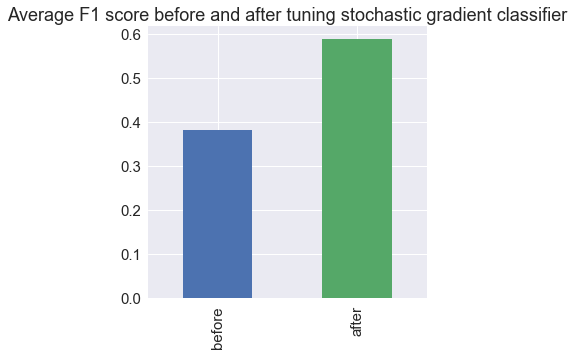

In [247]:
sgd_df.mean().plot('bar').set_title('Average F1 score before and after tuning stochastic gradient classifier')

Text(0.5,1,'Average F1 score before and after tuning support vector machine classifier')

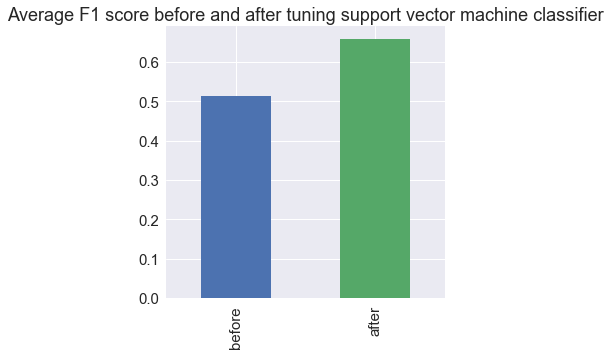

In [254]:
svc_df.mean().plot('bar').set_title('Average F1 score before and after tuning support vector machine classifier')

Text(0.5,1,'Average F1 score before and after tuning naive bayes classifier')

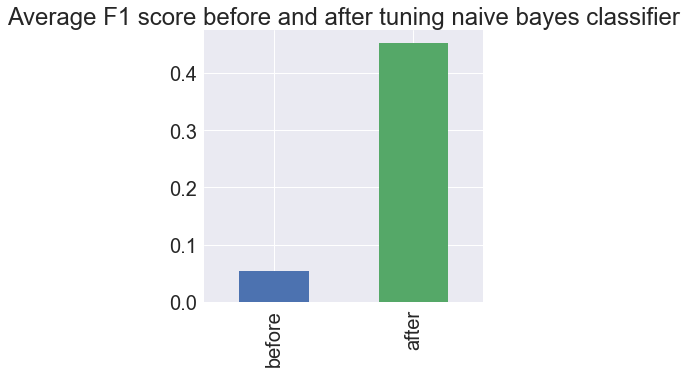

In [59]:
nb_df.mean().plot('bar').set_title('Average F1 score before and after tuning naive bayes classifier')